# 04_cnn_model

Einfache CNN-Baseline für CVE Severity Klassifikation basierend auf den Varianten aus `02_preprocessing_variants.ipynb`.

Varianten-Dateien:`,`- cves_processed_tfidf_var_raw.csv`,`- cves_processed_tfidf_var_clean.csv

Diese Baseline verwendet:
- Tokenisierung per Whitespace (keine zusätzlichen Regeln)
- Begrenztes Vokabular nach Häufigkeit
- Padding/Truncation fester Sequenzlänge
- Embedding + 1D Convolution + Global Max Pool + Linear
- Loss: CrossEntropyLoss
- Optimizer: Adam

Keine zusätzlichen Features oder Experimente hinzugefügt.

## 1. Imports & Konfiguration

In [12]:
from pathlib import Path
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
VARIANT = 'clean'  # 'clean' oder 'raw'
DATA_DIR = Path('../data/processed/tfidf')
FILE_MAP = { 'clean': 'cves_processed_tfidf_var_clean.csv', 'raw': 'cves_processed_tfidf_var_raw.csv' }
variant_file = DATA_DIR / FILE_MAP[VARIANT]
assert variant_file.exists(), f'Fehlende Variantendatei: {variant_file}'

MIN_CLASS_COUNT = 2
EXCLUDE_SEVERITIES = {'none', 'None', 'NONE'}  # zu entfernende Severity-Bezeichner
MAX_VOCAB = 20000
MAX_LEN = 200  # maximale Tokens pro Beispiel
BATCH_SIZE = 32
EMBED_DIM = 100
FILTERS = 128
KERNEL_SIZE = 5
DROPOUT = 0.5
EPOCHS = 10  # etwas höher, da jetzt eigene Val
LR = 1e-3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print({'variant': VARIANT, 'file': str(variant_file), 'device': str(DEVICE)})

{'variant': 'clean', 'file': '../data/processed/tfidf/cves_processed_tfidf_var_clean.csv', 'device': 'cpu'}


## 2. Daten laden & seltene Klassen entfernen

In [13]:
df = pd.read_csv(variant_file)
req = {'cve_id','severity','severity_id','description_clean'}
missing = req - set(df.columns)
assert not missing, f'Missing columns: {missing}'
print('Original shape:', df.shape)
# Entferne explizit ausgeschlossene Severities (z.B. "None")
if 'EXCLUDE_SEVERITIES' in globals() and EXCLUDE_SEVERITIES:
    before = len(df)
    lower_excl = {s.lower() for s in EXCLUDE_SEVERITIES}
    df = df[~df['severity'].astype(str).str.lower().isin(lower_excl)].copy()
    removed = before - len(df)
    if removed:
        print(f'Entfernt (excluded severities): {removed}')
vc = df['severity_id'].value_counts()
rare = vc[vc < MIN_CLASS_COUNT].index.tolist()
if rare:
    print('Entferne seltene Klassen:', {int(k): int(vc[k]) for k in rare})
    df = df[~df['severity_id'].isin(rare)].copy()
print('Shape nach Entfernen:', df.shape)
label_counts = df['severity_id'].value_counts().sort_index().to_dict()
print('Label counts:', label_counts)

Original shape: (172908, 4)
Entfernt (excluded severities): 5
Shape nach Entfernen: (172903, 4)
Label counts: {1: 3272, 2: 73420, 3: 69423, 4: 26788}


## 3. Train/Test Split

In [14]:
texts = df['description_clean'].astype(str).values
labels_original = df['severity_id'].values
# Erzeuge stetige Label-Indices 0..K-1
unique_labels = sorted(pd.Series(labels_original).unique())
label2idx = {lab: i for i, lab in enumerate(unique_labels)}
idx2label = {i: lab for lab, i in label2idx.items()}
labels = np.array([label2idx[l] for l in labels_original], dtype=np.int64)
# Erst train/test
X_train_text, X_test_text, y_train, y_test = train_test_split(texts, labels, test_size=0.15, stratify=labels, random_state=RANDOM_STATE)
# Dann train -> train/val
X_train_text, X_val_text, y_train, y_val = train_test_split(X_train_text, y_train, test_size=0.1765, stratify=y_train, random_state=RANDOM_STATE)  # 0.1765*0.85 ~= 0.15 => 70/15/15
print({'train': len(X_train_text), 'val': len(X_val_text), 'test': len(X_test_text), 'num_classes': len(unique_labels), 'original_labels': unique_labels})

{'train': 121027, 'val': 25940, 'test': 25936, 'num_classes': 4, 'original_labels': [1, 2, 3, 4]}


## 4. Tokenisierung & Vokabular

In [15]:
def tokenize(s):
    return s.split()

from collections import Counter
counter = Counter()
for t in X_train_text:
    counter.update(tokenize(t))
most_common = counter.most_common(MAX_VOCAB - 2)  # Platz für PAD + UNK
itos = ['<PAD>','<UNK>'] + [w for w,_ in most_common]
stoi = {w:i for i,w in enumerate(itos)}
PAD_IDX = stoi['<PAD>']
UNK_IDX = stoi['<UNK>']
print('Vokabgröße:', len(itos))

Vokabgröße: 20000


## 5. Sequenzumwandlung & Padding

In [16]:
def encode(text):
    ids = [stoi.get(tok, UNK_IDX) for tok in tokenize(text)]
    if len(ids) > MAX_LEN:
        ids = ids[:MAX_LEN]
    else:
        ids += [PAD_IDX] * (MAX_LEN - len(ids))
    return ids

X_train_ids = np.array([encode(t) for t in X_train_text], dtype=np.int32)
X_val_ids = np.array([encode(t) for t in X_val_text], dtype=np.int32)
X_test_ids = np.array([encode(t) for t in X_test_text], dtype=np.int32)
print('Encoded shapes:', X_train_ids.shape, X_val_ids.shape, X_test_ids.shape)

Encoded shapes: (121027, 200) (25940, 200) (25936, 200)


## 6. Dataset & DataLoader

In [17]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).long()
        self.y = torch.from_numpy(y).long()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = TextDataset(X_train_ids, y_train)
val_ds = TextDataset(X_val_ids, y_val)
test_ds = TextDataset(X_test_ids, y_test)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)
print({'train_batches': len(train_loader), 'val_batches': len(val_loader), 'test_batches': len(test_loader)})

{'train_batches': 3783, 'val_batches': 811, 'test_batches': 811}


## 7. Modell

In [18]:
class CNNText(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, pad_idx, filters, kernel_size, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.conv = nn.Conv1d(embed_dim, filters, kernel_size, padding=kernel_size//2)
        self.act = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(filters, num_classes)
    def forward(self, x):
        emb = self.embedding(x)             # (B, L, E)
        emb_t = emb.transpose(1,2)          # (B, E, L)
        h = self.conv(emb_t)                # (B, F, L)
        h = self.act(h)
        h = self.pool(h).squeeze(-1)        # (B, F)
        h = self.drop(h)
        return self.fc(h)

num_classes = len(unique_labels)
model = CNNText(len(itos), EMBED_DIM, num_classes, PAD_IDX, FILTERS, KERNEL_SIZE, DROPOUT).to(DEVICE)
print({'model': 'CNNText', 'num_classes': num_classes, 'vocab_size': len(itos), 'dropout': DROPOUT})

{'model': 'CNNText', 'num_classes': 4, 'vocab_size': 20000, 'dropout': 0.5}


## 8. Training Loop

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Verlaufslisten für Plots
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': [],
    'train_f1': [], 'val_f1': []
}

def run_epoch(loader, train=True):
    if train:
        model.train()
    else:
        model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    for Xb, yb in loader:
        Xb = Xb.to(DEVICE)
        yb = yb.to(DEVICE)
        with torch.set_grad_enabled(train):
            out = model(Xb)
            loss = criterion(out, yb)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        total_loss += loss.item() * Xb.size(0)
        preds = out.argmax(1).detach().cpu().numpy()
        all_preds.append(preds)
        all_labels.append(yb.detach().cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    return total_loss/len(loader.dataset), acc, macro_f1, all_preds, all_labels

for epoch in range(1, EPOCHS+1):
    train_loss, train_acc, train_f1, _, _ = run_epoch(train_loader, train=True)
    val_loss, val_acc, val_f1, _, _ = run_epoch(val_loader, train=False)
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['train_f1'].append(train_f1)
    history['val_f1'].append(val_f1)
    print(f'Epoch {epoch}: train_loss={train_loss:.4f} acc={train_acc:.4f} f1={train_f1:.4f} | val_loss={val_loss:.4f} acc={val_acc:.4f} f1={val_f1:.4f}')

Epoch 1: train_loss=0.8427 acc=0.6278 f1=0.4503 | val_loss=0.7255 acc=0.6860 f1=0.4946
Epoch 2: train_loss=0.7425 acc=0.6860 f1=0.5184 | val_loss=0.7005 acc=0.7053 f1=0.5502
Epoch 2: train_loss=0.7425 acc=0.6860 f1=0.5184 | val_loss=0.7005 acc=0.7053 f1=0.5502
Epoch 3: train_loss=0.6909 acc=0.7138 f1=0.5549 | val_loss=0.6809 acc=0.7179 f1=0.5748
Epoch 3: train_loss=0.6909 acc=0.7138 f1=0.5549 | val_loss=0.6809 acc=0.7179 f1=0.5748
Epoch 4: train_loss=0.6540 acc=0.7324 f1=0.5844 | val_loss=0.6827 acc=0.7167 f1=0.5684
Epoch 4: train_loss=0.6540 acc=0.7324 f1=0.5844 | val_loss=0.6827 acc=0.7167 f1=0.5684
Epoch 5: train_loss=0.6205 acc=0.7498 f1=0.6108 | val_loss=0.6847 acc=0.7210 f1=0.5885
Epoch 5: train_loss=0.6205 acc=0.7498 f1=0.6108 | val_loss=0.6847 acc=0.7210 f1=0.5885
Epoch 6: train_loss=0.5913 acc=0.7629 f1=0.6294 | val_loss=0.6945 acc=0.7209 f1=0.5711
Epoch 6: train_loss=0.5913 acc=0.7629 f1=0.6294 | val_loss=0.6945 acc=0.7209 f1=0.5711
Epoch 7: train_loss=0.5675 acc=0.7729 f1=0.

## 9. Finale Evaluation

In [20]:
_, _, _, test_preds_idx, test_labels_idx = run_epoch(test_loader, train=False)
# Mapping zurück zu originalen severity_ids
preds_original = np.array([idx2label[i] for i in test_preds_idx])
labels_original_eval = np.array([idx2label[i] for i in test_labels_idx])
print('Original label mapping:', idx2label)
print(classification_report(labels_original_eval, preds_original, digits=4))
# Speichere für spätere Plots
test_preds_idx_stored = test_preds_idx
test_labels_idx_stored = test_labels_idx

Original label mapping: {0: 1, 1: 2, 2: 3, 3: 4}
              precision    recall  f1-score   support

           1     0.6977    0.1833    0.2903       491
           2     0.7612    0.8083    0.7841     11013
           3     0.7058    0.6978    0.7018     10414
           4     0.6316    0.6000    0.6154      4018

    accuracy                         0.7198     25936
   macro avg     0.6991    0.5724    0.5979     25936
weighted avg     0.7177    0.7198    0.7156     25936



## Ende

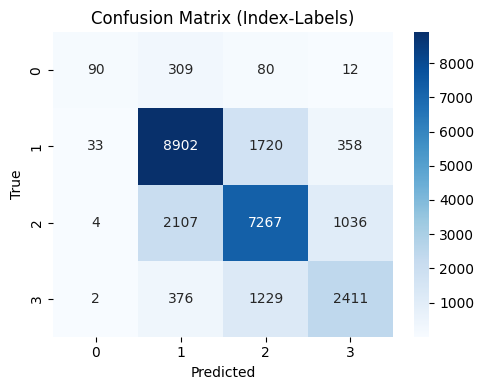

Accuracy : 0.7198488587291795
Precision: 0.6990938683437845
Recall   : 0.5723693118889006
MCC      : 0.5531324510925161


In [21]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, matthews_corrcoef
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_labels_idx_stored, test_preds_idx_stored)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Index-Labels)')
plt.tight_layout()
plt.show()

print('Accuracy :', accuracy_score(test_labels_idx_stored, test_preds_idx_stored))
print('Precision:', precision_score(test_labels_idx_stored, test_preds_idx_stored, average='macro', zero_division=0))
print('Recall   :', recall_score(test_labels_idx_stored, test_preds_idx_stored, average='macro', zero_division=0))
print('MCC      :', matthews_corrcoef(test_labels_idx_stored, test_preds_idx_stored))

## 10. Trainingsverlauf & Konfusionsmatrix

## 11. Param-Sweep (Embedding/Vocab/Kernel)
Wir führen jetzt einen kleinen Sweep über EMBED_DIM, MAX_VOCAB, FILTERS & KERNEL_SIZE aus und loggen Ergebnisse nach `../results/cnn_sweeps.csv`.

In [ ]:
import time, math, csv
from itertools import product
from copy import deepcopy

SWEEP_RESULTS = Path('../results/cnn_sweeps.csv')
embed_dims = [50, 100]
max_vocabs = [10000, 20000]
filter_sizes = [64, 128]
kernel_sizes = [3,5]

def build_vocab(texts, max_vocab):
    from collections import Counter
    c = Counter()
    for t in texts:
        c.update(t.split())
    most = c.most_common(max_vocab-2)
    itos_local = ['<PAD>','<UNK>'] + [w for w,_ in most]
    stoi_local = {w:i for i,w in enumerate(itos_local)}
    return itos_local, stoi_local

def encode_batch(texts_arr, stoi_local, max_len):
    PAD = stoi_local.get('<PAD>',0)
    UNK = stoi_local.get('<UNK>',1)
    out = []
    for t in texts_arr:
        toks = t.split()
        ids = [stoi_local.get(tok, UNK) for tok in toks][:max_len]
        if len(ids) < max_len:
            ids += [PAD]*(max_len-len(ids))
        out.append(ids)
    return np.array(out, dtype=np.int32)

header = ['run_id','variant','embed_dim','max_vocab','filters','kernel_size','epochs','train_loss','val_loss','train_acc','val_acc','train_f1','val_f1','duration_sec','params_count']
if not SWEEP_RESULTS.exists():
    with open(SWEEP_RESULTS,'w',newline='') as f:
        csv.writer(f).writerow(header)

run_id = int(time.time())
for (ed, mv, fs, ks) in product(embed_dims, max_vocabs, filter_sizes, kernel_sizes):
    t0 = time.time()
    itos_s, stoi_s = build_vocab(X_train_text, mv)
    Xtr_ids = encode_batch(X_train_text, stoi_s, MAX_LEN)
    Xval_ids = encode_batch(X_val_text, stoi_s, MAX_LEN)
    tr_ds = TextDataset(Xtr_ids, y_train)
    val_ds_l = TextDataset(Xval_ids, y_val)
    tr_loader = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader_l = DataLoader(val_ds_l, batch_size=BATCH_SIZE)

    sweep_model = CNNText(len(itos_s), ed, num_classes, stoi_s['<PAD>'], fs, ks, DROPOUT).to(DEVICE)
    opt = torch.optim.Adam(sweep_model.parameters(), lr=LR)
    crit = nn.CrossEntropyLoss()

    hist_local = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[], 'train_f1':[], 'val_f1':[]}
    for ep in range(3):  # kurze Laufzeit für Vergleich, später erhöhen
        # train
        sweep_model.train(); tl=0; all_p=[]; all_l=[]
        for xb,yb in tr_loader:
            xb=xb.to(DEVICE); yb=yb.to(DEVICE)
            out=sweep_model(xb); loss=crit(out,yb)
            opt.zero_grad(); loss.backward(); opt.step()
            tl += loss.item()*xb.size(0)
            p=out.argmax(1).detach().cpu().numpy(); all_p.append(p); all_l.append(yb.cpu().numpy())
        all_p=np.concatenate(all_p); all_l=np.concatenate(all_l)
        tr_loss = tl/len(tr_loader.dataset)
        tr_acc = accuracy_score(all_l, all_p)
        tr_f1 = f1_score(all_l, all_p, average='macro')
        # val
        sweep_model.eval(); vl=0; vp=[]; vlb=[]
        with torch.no_grad():
            for xb,yb in val_loader_l:
                xb=xb.to(DEVICE); yb=yb.to(DEVICE)
                out=sweep_model(xb); loss=crit(out,yb)
                vl += loss.item()*xb.size(0)
                p=out.argmax(1).cpu().numpy(); vp.append(p); vlb.append(yb.cpu().numpy())
        vp=np.concatenate(vp); vlb=np.concatenate(vlb)
        v_loss = vl/len(val_loader_l.dataset)
        v_acc = accuracy_score(vlb, vp)
        v_f1 = f1_score(vlb, vp, average='macro')
        hist_local['train_loss'].append(tr_loss); hist_local['val_loss'].append(v_loss)
        hist_local['train_acc'].append(tr_acc); hist_local['val_acc'].append(v_acc)
        hist_local['train_f1'].append(tr_f1); hist_local['val_f1'].append(v_f1)
    duration = time.time()-t0
    params_count = sum(p.numel() for p in sweep_model.parameters())
    with open(SWEEP_RESULTS,'a',newline='') as f:
        csv.writer(f).writerow([run_id, VARIANT, ed, mv, fs, ks, 3,
                                hist_local['train_loss'][-1], hist_local['val_loss'][-1],
                                hist_local['train_acc'][-1], hist_local['val_acc'][-1],
                                hist_local['train_f1'][-1], hist_local['val_f1'][-1],
                                round(duration,2), params_count])
print('Sweep abgeschlossen. Ergebnisse in', SWEEP_RESULTS)

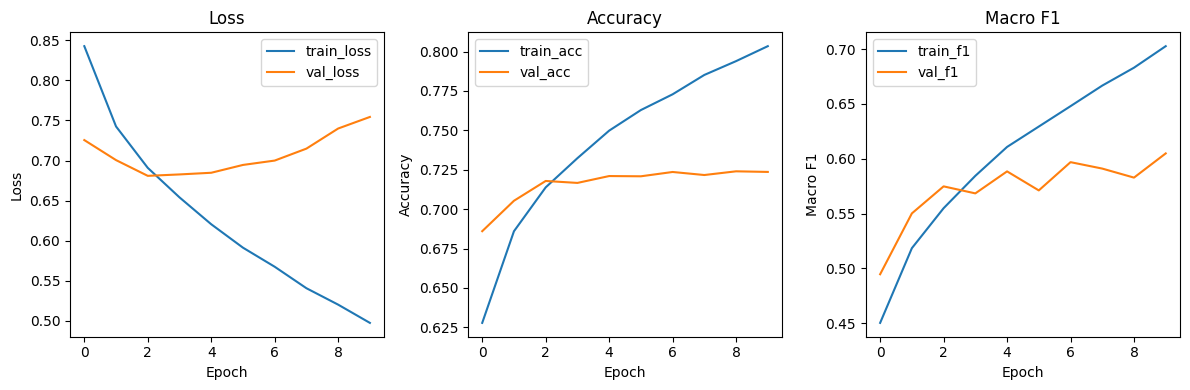

: 

In [ ]:
import matplotlib.pyplot as plt

# Loss Kurven
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

# Accuracy Kurven
plt.subplot(1,3,2)
plt.plot(history['train_acc'], label='train_acc')
plt.plot(history['val_acc'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

# Macro F1 Kurven
plt.subplot(1,3,3)
plt.plot(history['train_f1'], label='train_f1')
plt.plot(history['val_f1'], label='val_f1')
plt.xlabel('Epoch')
plt.ylabel('Macro F1')
plt.title('Macro F1')
plt.legend()
plt.tight_layout()
plt.show()